# Movie ratings


In [244]:
# useful packages
import numpy as np
import csv
import math
import pandas as pd
from sklearn import preprocessing
from sklearn import datasets
from sklearn import cluster
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import itertools

# load the browsing history data
user_history = pd.read_csv("user_history.csv")
user_history_without_user_ID = user_history.drop(['USER ID'],axis=1)
user_history_indexed = user_history.set_index('USER ID')
user_ratings = pd.read_csv("user_ratings.csv")

# load the ratings data
train = pd.read_csv("train_rating.csv")
test = pd.read_csv("test_rating.csv")

In [245]:
row_id_to_ind = dict(zip(user_history['USER ID'].to_numpy(), range(len(user_history['USER ID'].to_numpy()))))
ind_to_row_id = dict(zip(range(len(user_history['USER ID'].to_numpy())), user_history['USER ID'].to_numpy()))

website_id_to_ind = dict(zip(user_history_indexed.columns.to_numpy(), range(len(user_history_indexed.columns.to_numpy()))))
ind_to_website_id = dict(zip(range(len(user_history_indexed.columns.to_numpy())), user_history_indexed.columns.to_numpy()))

col_id_to_ind = dict(zip(train['PRODUCT'].unique(), range(len(train['PRODUCT'].unique()))))
ind_to_col_id = dict(zip(range(len(train['PRODUCT'].unique())), train['PRODUCT'].unique()))

In [246]:
learning_rate = 0.005

train_ratings = train['RATING']
train_rows = train['USER ID']
train_cols = train['PRODUCT']
test_ratings = test['RATING']
test_rows = test['USER ID']
test_cols = test['PRODUCT']

m = len(train_ratings) # the size of the training set                             #30352
n_rows = user_history['USER ID'].unique().shape[0] # the largest index, plus 1    #4500
n_cols = train_cols.unique().shape[0]                                             #75

train_rows_inds = np.array([row_id_to_ind[r] for r in train_rows])
train_cols_inds = np.array([col_id_to_ind[c] for c in train_cols])

test_rows_inds = np.array([row_id_to_ind[r] for r in test_rows])
test_cols_inds = np.array([col_id_to_ind[c] for c in test_cols])

In [247]:
train_data_stats = csv.reader(open('train_rating_stats.csv','r'))
train_mean_and_std = [row[0] for row in train_data_stats][1:]
train_data_mean = float(train_mean_and_std[0])
train_data_std = float(train_mean_and_std[1])

train_ratings_unnormalized = train_ratings.copy()
train_ratings_unnormalized *= train_data_std
train_ratings_unnormalized += train_data_mean

In [248]:
def initialize(n_rows, n_cols, row_features=np.array([]), col_features=np.array([]), k=15):
    
    """Initalize a random model, and normalize it so that it has sensible mean and variance"""
    # (The normalization helps make sure we start out at a reasonable parameter scale, which speeds up training)
    if row_features.size != 0:
        k = row_features.shape[1]
    elif col_features.size != 0:
        k = col_features.shape[1]
    if row_features.size == 0:
        row_features = np.random.normal(size=(n_rows, k))
    else:
        row_features -= row_features.mean(axis=1)[:,None]
        row_features /= row_features.std(axis=1)[:,None]
    if col_features.size == 0:
        col_features = np.random.normal(size=(n_cols, k))
        
    raw_predictions = predict((row_features, col_features))
    
    s = np.sqrt(2*raw_predictions.std()) # We want to start out with roughly unit variance
    b = np.sqrt((train_data_mean - raw_predictions.mean()/s)/k) #We want to start out with average rating 3.5
    row_features /= s
    row_features += b
    col_features /= s
    col_features += b
    
    return (row_features, col_features)

def predict(model):
    """The model's predictions for all row/col pairs"""
    row_features, col_features = model
    return row_features @ col_features.T

def single_example_step(model, row, col, rating):
    """Update the model using the gradient at a single training example"""
    row_features, col_features = model
    residual = np.dot(row_features[row], col_features[col]) - rating
    grad_rows = 2 * residual * col_features[col] # the gradient for the row_features matrix
    grad_cols = 2 * residual * row_features[row] # the gradient for the col_features matrix
    row_features[row] -= learning_rate*grad_rows
    col_features[col] -= learning_rate*grad_cols

def train_sgd(model, num_epochs, batch_size):
    """Train the model for a number of epochs via SGD (batch size=1)"""
    row_features, col_features = model
    train_MSEs = []
    test_MSEs = []
    # It's good practice to shuffle your data before doing batch gradient descent,
    # so that each mini-batch peforms like a random sample from the dataset
    for epoch in range(num_epochs):
        shuffle = np.random.permutation(m) 
        shuffled_rows = train_rows[shuffle]
        shuffled_cols = train_cols[shuffle]
        shuffled_ratings = train_ratings[shuffle]
        for row, col, rating in zip(shuffled_rows[:batch_size], shuffled_cols[:batch_size], shuffled_ratings[:batch_size]):
            # update the model using the gradient at a single example
            single_example_step(model, row_id_to_ind[row], col_id_to_ind[col], rating)
        # after each Epoch, we'll evaluate our model
        predicted = predict(model)        
        predicted_unnormalized = predicted.copy()
        predicted_unnormalized *= train_data_std
        predicted_unnormalized += train_data_mean
        train_loss = np.mean((train_ratings_unnormalized - predicted_unnormalized[train_rows_inds, train_cols_inds])**2)
        test_loss = np.mean((test_ratings - predicted_unnormalized[test_rows_inds, test_cols_inds])**2)
#         print("Loss after epoch #{} is: train/{} --- test/{}".format(epoch+1, train_loss, test_loss))
        train_MSEs.append(train_loss)
        test_MSEs.append(test_loss)
    return predicted_unnormalized, train_MSEs[20:], test_MSEs[20:]

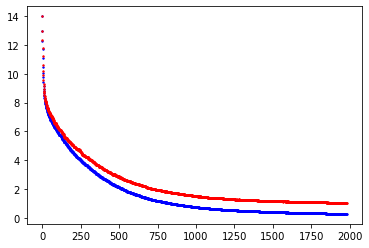

In [249]:
row_features = user_history_indexed.to_numpy()
sgd_model = initialize(n_rows, n_cols, row_features=row_features)
predictions, train_MSEs, test_MSEs = train_sgd(sgd_model, num_epochs=2000, batch_size=100)

plt.scatter(np.array(range(len(train_MSEs))), np.array(train_MSEs), s=2, c='b', marker='o')
plt.scatter(np.array(range(len(test_MSEs))), np.array(test_MSEs), s=2, c='r', marker='o')

In [252]:
np.sqrt(test_MSEs[-1])

1.0265556057606662